### **INSTALL AND IMPORT LIBRARIES**

In [1]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version PyTorch built with:", torch.version.cuda)
print("GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected!")

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import os
import json
import joblib

import warnings
warnings.filterwarnings('ignore')

import fasttext
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, pipeline, logging

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, ParameterGrid, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import shap
import matplotlib.pyplot as plt

import tempfile
from pathlib import Path
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from utils import synthesize_dataset, run_ablation_benchmark

Torch version: 2.4.1+cu118
CUDA available: True
CUDA version PyTorch built with: 11.8
GPU device: NVIDIA GeForce GTX 1660


### **IMPORT THE DATASET**

In [2]:
# Load the dataset
df_train = pd.read_parquet("../data/processed/dataset_train.parquet")
df_test = pd.read_parquet("../data/processed/dataset_test.parquet")

### **TRAIN THE TEXTUAL MODELS**

In [ ]:
# Get textual features and labels
df_text_train = df_train[['visible_text', 'result']]
df_text_test = df_test[['visible_text', 'result']]

df_text_train_labels = df_text_train['result'].values
df_text_test_labels = df_text_test['result'].values

**FASTTEXT**

In [ ]:
# Set the model name
model_name = "fasttext"

# Prepare the datasets with token limit
def save_fasttext_format(df, filename, max_tokens=512):
    with open(filename, "w", encoding="utf-8") as f:
        for _, row in df.iterrows():
            label = row["result"]
            text = row["visible_text"].replace("\n", " ")
            tokens = text.split()
            trimmed_text = " ".join(tokens[:max_tokens])
            f.write(f"__label__{label} {trimmed_text}\n")

save_fasttext_format(df_text_train, "../data/processed/fasttext_train.txt")

# Train the model
fasttext_model = fasttext.train_supervised(
    input="../data/processed/fasttext_train.txt",
    lr=1.0,
    epoch=25,
    wordNgrams=2,
    verbose=2,
    minCount=1,
    loss='softmax',
    seed=42
)

# Quantize the model
fasttext_model.quantize(
    input="../data/processed/fasttext_train.txt",
    retrain=True,   # Re-train vectors before quantization
    qnorm=True,     # Quantize norms as well
    dsub=2          # Sub-vector size (smaller → smaller model)
)

# Save the quantized model
model_dir = f"../models/textual/{model_name}"
os.makedirs(model_dir, exist_ok=True)
fasttext_model_path = os.path.join(model_dir, "model.ftz")
fasttext_model.save_model(fasttext_model_path)
print("Quantized FastText textual model saved!")

Quantized FastText textual model saved!


**DISTILBERT**

In [ ]:
# Set the model name
model_name = "distilbert"

# Tokenize train and test data
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
distilbert_train_encodings = distilbert_tokenizer(df_text_train['visible_text'].tolist(), truncation=True, padding=True, max_length=512)
distilbert_test_encodings = distilbert_tokenizer(df_text_test['visible_text'].tolist(), truncation=True, padding=True, max_length=512)

# Prepare the datasets
distilbert_train_dataset = Dataset.from_dict({
    'input_ids': distilbert_train_encodings['input_ids'],
    'attention_mask': distilbert_train_encodings['attention_mask'],
    'label': df_text_train_labels.tolist()
})
distilbert_test_dataset = Dataset.from_dict({
    'input_ids': distilbert_test_encodings['input_ids'],
    'attention_mask': distilbert_test_encodings['attention_mask'],
    'label': df_text_test_labels.tolist()
})

# Initialize the model
distilbert_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Set the training arguments
distilbert_training_args = TrainingArguments(
    output_dir="./tmp",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5
)

# Initialize the trainer
distilbert_trainer = Trainer(
    model=distilbert_model,
    args=distilbert_training_args,
    train_dataset=distilbert_train_dataset,
    eval_dataset=distilbert_test_dataset
)

# Train the model
distilbert_trainer.train()

# Save the model and tokenizer
model_dir = f"../models/textual/{model_name}"
distilbert_model.save_pretrained(model_dir)
distilbert_tokenizer.save_pretrained(model_dir)
print("DistilBERT model and tokenizer saved!")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.203700,0.153628
2,0.116900,0.179763
3,0.082800,0.176999
4,0.059600,0.169286
5,0.045200,0.184922


DistilBERT model and tokenizer saved!


**TINYBERT**

In [ ]:
# Set the model name
model_name = "tinybert"

# Tokenize train and test data
tinybert_tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
tinybert_train_encodings = tinybert_tokenizer(df_text_train['visible_text'].tolist(), truncation=True, padding=True, max_length=512)
tinybert_test_encodings = tinybert_tokenizer(df_text_test['visible_text'].tolist(), truncation=True, padding=True, max_length=512)

# Prepare the datasets
tinybert_train_dataset = Dataset.from_dict({
    'input_ids': tinybert_train_encodings['input_ids'],
    'attention_mask': tinybert_train_encodings['attention_mask'],
    'label': df_text_train_labels.tolist()
})
tinybert_test_dataset = Dataset.from_dict({
    'input_ids': tinybert_test_encodings['input_ids'],
    'attention_mask': tinybert_test_encodings['attention_mask'],
    'label': df_text_test_labels.tolist()
})

# Initialize the model
tinybert_model = AutoModelForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', num_labels=2)

# Set the training arguments
tinybert_training_args = TrainingArguments(
    output_dir="./tmp",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5
)

# Initialize the trainer
tinybert_trainer = Trainer(
    model=tinybert_model,
    args=tinybert_training_args,
    train_dataset=tinybert_train_dataset,
    eval_dataset=tinybert_test_dataset
)

# Train the model
tinybert_trainer.train()

# Save the model and tokenizer
model_dir = f"../models/textual/{model_name}"
tinybert_model.save_pretrained(model_dir)
tinybert_tokenizer.save_pretrained(model_dir)
print("TinyBERT model and tokenizer saved!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.247100,0.184714
2,0.142500,0.188289
3,0.098800,0.199310
4,0.069100,0.187275
5,0.053900,0.201175


TinyBERT model and tokenizer saved!


### **EVALUATE THE TEXTUAL MODELS**

**CLASSIFICATION PERFORMANCE**

In [ ]:
classification_performance_results = []

# Evaluate the trained FastText model
fasttext_model = fasttext.load_model("../models/textual/fasttext/model.ftz")

texts = df_text_test["visible_text"].astype(str).tolist()
fasttext_labels = df_text_test_labels

def truncate_text(text, max_tokens=512):
    text = text.replace("\n", " ")
    tokens = text.split()
    return " ".join(tokens[:max_tokens])

fasttext_preds, fasttext_probs = [], []
for text in texts:
    truncated_text = truncate_text(text)
    labels, probabilities = fasttext_model.predict(truncated_text, k=2)

    # Extract predicted label
    pred = int(labels[0].replace("__label__", ""))
    fasttext_preds.append(pred)

    # Get probability for class 1
    prob_dict = {int(lbl.replace("__label__", "")): prob for lbl, prob in zip(labels, probabilities)}
    prob_class1 = prob_dict.get(1, 0.0)
    fasttext_probs.append(prob_class1)

classification_performance_results.append({
    "Model": "FastText",
    "Accuracy": accuracy_score(fasttext_labels, fasttext_preds),
    "Precision": precision_score(fasttext_labels, fasttext_preds),
    "Recall": recall_score(fasttext_labels, fasttext_preds),
    "F1-Score": f1_score(fasttext_labels, fasttext_preds)
})

# Evaluate the trained DistilBERT model
distilbert_model = DistilBertForSequenceClassification.from_pretrained("../models/textual/distilbert")
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained("../models/textual/distilbert")

distilbert_test_encodings = distilbert_tokenizer(df_text_test["visible_text"].tolist(), truncation=True, padding=True, max_length=512)
distilbert_test_dataset = Dataset.from_dict({
    "input_ids": distilbert_test_encodings["input_ids"],
    "attention_mask": distilbert_test_encodings["attention_mask"],
    "label": df_text_test_labels.tolist()
})

distilbert_trainer = Trainer(model=distilbert_model)
distilbert_preds = distilbert_trainer.predict(distilbert_test_dataset)
distilbert_labels = df_text_test_labels
distilbert_pred_classes = distilbert_preds.predictions.argmax(-1)
distilbert_probs = distilbert_preds.predictions[:, 1] # Get probability of class 1

classification_performance_results.append({
    "Model": "DistilBERT",
    "Accuracy": accuracy_score(distilbert_labels, distilbert_pred_classes),
    "Precision": precision_score(distilbert_labels, distilbert_pred_classes),
    "Recall": recall_score(distilbert_labels, distilbert_pred_classes),
    "F1-Score": f1_score(distilbert_labels, distilbert_pred_classes)
})

# Evaluate the trained TinyBERT model
tinybert_model = AutoModelForSequenceClassification.from_pretrained("../models/textual/tinybert")
tinybert_tokenizer = AutoTokenizer.from_pretrained("../models/textual/tinybert")

tinybert_test_encodings = tinybert_tokenizer(df_text_test["visible_text"].tolist(), truncation=True, padding=True, max_length=512)
tinybert_test_dataset = Dataset.from_dict({
    "input_ids": tinybert_test_encodings["input_ids"],
    "attention_mask": tinybert_test_encodings["attention_mask"],
    "label": df_text_test_labels.tolist()
})

tinybert_trainer = Trainer(model=tinybert_model)
tinybert_preds = tinybert_trainer.predict(tinybert_test_dataset)
tinybert_labels = df_text_test_labels
tinybert_pred_classes = tinybert_preds.predictions.argmax(-1)
tinybert_probs = tinybert_preds.predictions[:, 1] # Get probability of class 1

classification_performance_results.append({
    "Model": "TinyBERT",
    "Accuracy": accuracy_score(tinybert_labels, tinybert_pred_classes),
    "Precision": precision_score(tinybert_labels, tinybert_pred_classes),
    "Recall": recall_score(tinybert_labels, tinybert_pred_classes),
    "F1-Score": f1_score(tinybert_labels, tinybert_pred_classes)
})

# Save and display results
classification_performance_results_df = pd.DataFrame(classification_performance_results)
classification_performance_results_df = classification_performance_results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

os.makedirs("../results/textual", exist_ok=True)
classification_performance_results_df.to_csv("../results/textual/textual_classification_performance_benchmarks.csv", index=False)

print("Textual Classification Performance Benchmark Results:")
display(classification_performance_results_df)

Textual Classification Performance Benchmark Results:


,Model,Accuracy,Precision,Recall,F1-Score
0,DistilBERT,0.9680,0.959364,0.9774,0.968298
1,TinyBERT,0.9653,0.959147,0.9720,0.965531
2,FastText,0.9564,0.952419,0.9608,0.956591


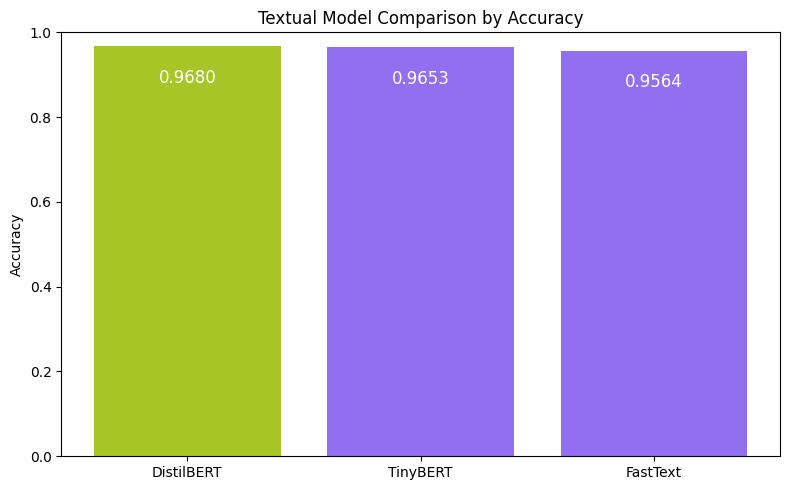

In [20]:
# Bar plot
df = pd.read_csv("../results/textual/textual_classification_performance_benchmarks.csv")

metric = "Accuracy"
best_idx = df[metric].idxmax()
colors = ["#A7C526" if i == best_idx else "#916FEE" for i in range(len(df))]

plt.figure(figsize=(8, 5))
bars = plt.bar(df["Model"], df[metric], color=colors)

for bar, val in zip(bars, df[metric]):
    plt.text(bar.get_x() + bar.get_width()/2, val * 0.90, f"{val:.4f}",
             ha='center', va='bottom', fontsize=12, color='white')

plt.title(f"Textual Model Comparison by {metric}")
plt.ylabel(metric)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig("../results/textual/textual_model_comparison_by_accuracy.png", dpi=300)
plt.show()

**ROC CURVE AND AUC SCORE**

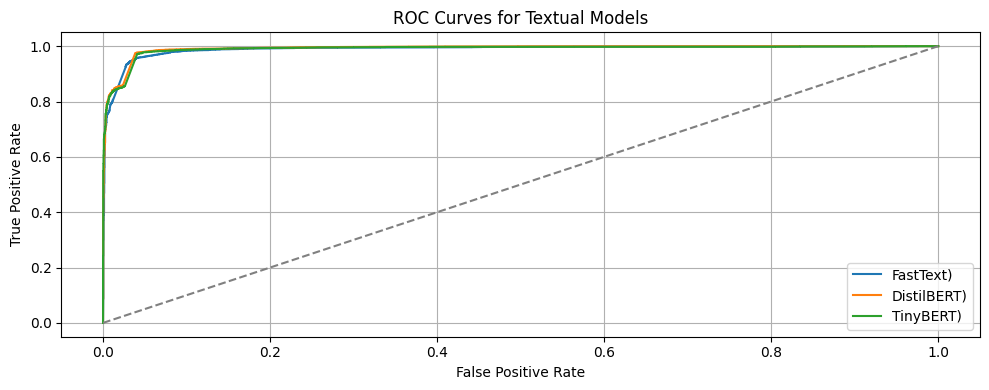


Textual ROC-AUC Scores:


,Model,ROC-AUC
0,DistilBERT,0.9913
1,TinyBERT,0.9899
2,FastText,0.9886


In [ ]:
# Unified function to plot all ROC curves and display AUC scores
def plot_textual_roc_curves(results, y_true):
    """
    Plots ROC curves for textual models and displays a table of ROC-AUC scores.

    Parameters:
        results (dict): {model_name: predicted_probabilities_for_class_1}
        y_true (list/array): Ground truth labels.
    """
    plt.figure(figsize=(10, 4))
    auc_table = []

    for model_name, probs in results.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        auc_score = roc_auc_score(y_true, probs)
        plt.plot(fpr, tpr, label=f"{model_name})")
        auc_table.append({"Model": model_name, "ROC-AUC": round(auc_score, 4)})

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curves for Textual Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.tight_layout()
    os.makedirs("../results/textual/", exist_ok=True)
    plt.savefig("../results/textual/textual_models_roc_curves.png", dpi=300)
    plt.show()

    # Save and display results
    df_auc = pd.DataFrame(auc_table).sort_values("ROC-AUC", ascending=False).reset_index(drop=True)
    df_auc.to_csv("../results/textual/textual_roc_auc_scores.csv", index=False)

    print("\nTextual ROC-AUC Scores:")
    display(df_auc)

# Create dict of model names
textual_probs_results = {
    "FastText": fasttext_probs,
    "DistilBERT": distilbert_probs,
    "TinyBERT": tinybert_probs
}

# Ground truth
y_true = df_text_test_labels

# Plot and save
plot_textual_roc_curves(textual_probs_results, y_true)

**CONFUSION MATRIX AND STATISTICS**

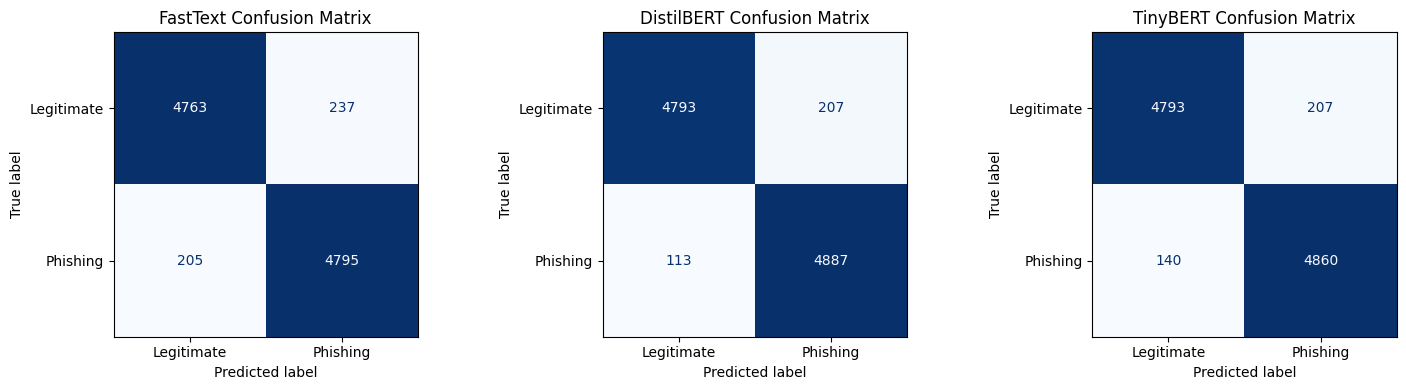


Textual Confusion Matrix Breakdown (%):


,True Positive (%),True Negative (%),False Positive (%),False Negative (%),Model
0,48.87,47.93,2.07,1.13,DistilBERT
1,48.60,47.93,2.07,1.40,TinyBERT
2,47.95,47.63,2.37,2.05,FastText


In [ ]:
# Utility function to compute confusion matrix stats
def get_confusion_stats(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    return {
        "True Positive (%)": round(tp / total * 100, 2),
        "True Negative (%)": round(tn / total * 100, 2),
        "False Positive (%)": round(fp / total * 100, 2),
        "False Negative (%)": round(fn / total * 100, 2),
    }

# Unified function to plot all confusion matrices and display stats
def plot_textual_confusion_matrices(results, y_true):
    """
    Plots textual confusion matrices side by side and displays a table of TP/TN/FP/FN percentages.

    Parameters:
        results (dict): {model_name: predicted_labels}
        y_true (list/array): Ground truth labels.
    """

    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

    # If only one model, axes might not be iterable
    if n_models == 1:
        axes = [axes]

    stats_table = []

    for ax, (model_name, y_pred) in zip(axes, results.items()):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
        disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)
        ax.set_title(f"{model_name} Confusion Matrix")

        stats = get_confusion_stats(y_true, y_pred)
        stats["Model"] = model_name
        stats_table.append(stats)

    plt.tight_layout()
    os.makedirs("../results/textual", exist_ok=True)
    plt.savefig("../results/textual/textual_confusion_matrices.png", bbox_inches="tight")
    plt.show()

    # Save and display results
    df_stats = pd.DataFrame(stats_table).sort_values("False Negative (%)").reset_index(drop=True)
    df_stats.to_csv("../results/textual/textual_confusion_matrix_breakdown.csv", index=False)

    print("\nTextual Confusion Matrix Breakdown (%):")
    display(df_stats)

# Get predictions and store in a dict
textual_results = {}

# FastText
texts = df_text_test["visible_text"].astype(str).tolist()
fasttext_preds = []
for text in texts:
    labels, _ = fasttext_model.predict(text.replace("\n", " ").strip(), k=1)
    fasttext_preds.append(int(labels[0].replace("__label__", "")))
textual_results["FastText"] = fasttext_preds

# DistilBERT
distilbert_preds = distilbert_trainer.predict(distilbert_test_dataset)
textual_results["DistilBERT"] = distilbert_preds.predictions.argmax(-1)

# TinyBERT
tinybert_preds = tinybert_trainer.predict(tinybert_test_dataset)
textual_results["TinyBERT"] = tinybert_preds.predictions.argmax(-1)

# Ground truth
y_true = df_text_test_labels

# Plot and save
plot_textual_confusion_matrices(textual_results, y_true)

**INFERENCE SPEED AND MODEL SIZE**

In [ ]:
# Configurations
MODEL_DIR = "../models"
DEVICE = "cpu"

# Prepare the test set
df_speed_test = df_text_test.copy()
texts = df_speed_test['visible_text'].astype(str).tolist()

# Load trained textual models and tokenizers
fasttext_model = fasttext.load_model(f"{MODEL_DIR}/textual/fasttext/model.ftz")

distilbert_model = DistilBertForSequenceClassification.from_pretrained(f"{MODEL_DIR}/textual/distilbert").to(DEVICE)
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(f"{MODEL_DIR}/textual/distilbert")

tinybert_model = AutoModelForSequenceClassification.from_pretrained(f"{MODEL_DIR}/textual/tinybert").to(DEVICE)
tinybert_tokenizer = AutoTokenizer.from_pretrained(f"{MODEL_DIR}/textual/tinybert")

# Function to truncate text for FastText
def truncate_text(text, max_tokens=512):
    tokens = text.replace("\n", " ").split()
    return " ".join(tokens[:max_tokens])

# Function to calculate inference speed
def get_inference_speed(name, predict_fn, texts, warmup=5):
    for _ in range(warmup): # Warm-up
        predict_fn(texts[0])

    start = time.time()
    for text in texts:
        predict_fn(text)
    end = time.time()

    total_time = end - start
    avg_time = total_time / len(texts)
    throughput = len(texts) / total_time

    return {
        "Model": name,
        "Average Time per Sample (sec)": round(avg_time, 6),
        "Throughput (samples/sec)": round(throughput, 2)
    }

# Function to get prediction for DistilBERT and TinyBERT
def get_prediction(model, tokenizer, max_length=512):
    def predict(text):
        inputs = tokenizer(
            text,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt"
        )
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}  # force to CPU
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        return probs
    return predict

# Get predictions
distilbert_prediction = get_prediction(distilbert_model, distilbert_tokenizer)
tinybert_prediction = get_prediction(tinybert_model, tinybert_tokenizer)

# Get inference speeds
inference_speed_results = []
inference_speed_results.append(get_inference_speed("FastText", lambda x: fasttext_model.predict(truncate_text(x)), texts))
inference_speed_results.append(get_inference_speed("DistilBERT", distilbert_prediction, texts))
inference_speed_results.append(get_inference_speed("TinyBERT", tinybert_prediction, texts))

# Function to get model size in MB
def get_model_size(path):
    total_size = 0
    if os.path.isfile(path):
        total_size = os.path.getsize(path)
    else:
        for dirpath, _, filenames in os.walk(path):
            for f in filenames:
                total_size += os.path.getsize(os.path.join(dirpath, f))
    return round(total_size / (1024 * 1024), 2)

# Get model sizes
fasttext_size = get_model_size(f"{MODEL_DIR}/textual/fasttext/model.ftz")
distilbert_size = get_model_size(f"{MODEL_DIR}/textual/distilbert")
tinybert_size = get_model_size(f"{MODEL_DIR}/textual/tinybert")

# Add sizes to results
model_sizes = [fasttext_size, distilbert_size, tinybert_size]
for result, size in zip(inference_speed_results, model_sizes):
    result["Model Size (MB)"] = size

# Save and display results
results_df = pd.DataFrame(inference_speed_results)
results_df = results_df.sort_values("Average Time per Sample (sec)").reset_index(drop=True)

os.makedirs("../results/textual", exist_ok=True)
results_df.to_csv("../results/textual/textual_speed_and_size_benchmarks.csv", index=False)

print("Textual Inference Speed and Model Size Benchmark Results:")
display(results_df)

Textual Inference Speed and Model Size Benchmark Results:


,Model,Average Time per Sample (sec),Throughput (samples/sec),Model Size (MB)
0,FastText,0.000128,7796.27,131.49
1,TinyBERT,0.015707,63.67,55.65
2,DistilBERT,0.074193,13.48,256.33


**FINAL TEXTUAL MODEL**

FastText will be selected as the textual backbone of PhiLNet because it provides an optimal balance between predictive performance and real-time efficiency. While transformer models like DistilBERT offered slightly higher accuracy, FastText achieves nearly equivalent predictive power (Accuracy = 0.9564, ROC-AUC = 0.9886) at a fraction of the inference time. With its lightweight 131 MB footprint and throughput exceeding 7,700 samples per second, FastText ensures that the textual analysis component can operate seamlessly in a real-time centralized API environment. This makes it the ideal candidate for capturing linguistic cues of phishing attacks without imposing heavy computational overhead.

### **TRAIN THE HEURISTIC MODELS**

In [3]:
# Get heuristic features and labels
df_gbm_train = df_train.drop(columns=['url', 'visible_text'])
df_gbm_test = df_test.drop(columns=['url', 'visible_text'])

X_train = df_gbm_train.drop(columns=['result'])
y_train = df_gbm_train['result']

X_test = df_gbm_test.drop(columns=['result'])
y_test = df_gbm_test['result']

In [4]:
# Convert boolean columns to integers
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# Convert to dictionary
X_train_dict = X_train.to_dict(orient="records")
X_test_dict = X_test.to_dict(orient="records")

# Initialize DictVectorizer and transform the data
vectorizer = DictVectorizer(sparse=False)
X_train_np = vectorizer.fit_transform(X_train_dict)
X_test_np = vectorizer.transform(X_test_dict)

**ADABOOST**

In [ ]:
# Setup
model_name = "adaboost"
model_dir = f"../models/heuristic/{model_name}"
os.makedirs(model_dir, exist_ok=True)

# Parameter grid
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.5, 1.0, 1.5],
    "algorithm": ["SAMME", "SAMME.R"]
}

# Initialize model and cross-validation
model = AdaBoostClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Manual grid search with tqdm
grid = ParameterGrid(param_grid)
best_score = -np.inf
best_params = None

for params in tqdm(grid, desc="Grid Search Progress"):
    model.set_params(**params)
    scores = cross_val_score(model, X_train_np, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    mean_score = np.mean(scores)

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

# Save results
os.makedirs("../results/heuristic", exist_ok=True)
best_result = {**best_params, "best_score": best_score}
best_df = pd.DataFrame([best_result])
best_df.to_csv(f"../results/heuristic/{model_name}_grid_search_results.csv", index=False)

# Train model on best parameters
best_model = AdaBoostClassifier(random_state=42, **best_params)
best_model.fit(X_train_np, y_train)

# Save model and vectorizer
joblib.dump(best_model, os.path.join(model_dir, "model.pkl"))
joblib.dump(vectorizer, os.path.join(model_dir, "vectorizer.pkl"))
print("AdaBoost heuristic model and vectorizer saved!")

Grid Search Progress: 100%|████████████████████████████████████████████████████████████| 40/40 [03:30<00:00,  5.25s/it]


AdaBoost heuristic model and vectorizer saved!


**XGBOOST**

In [ ]:
# Setup
model_name = "xgboost"
model_dir = f"../models/heuristic/{model_name}"
os.makedirs(model_dir, exist_ok=True)

# Parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.6, 0.8],
    "gamma": [0, 0.1],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1.0, 2.0],
    "scale_pos_weight": [1, 2]
}

# Initialize model and cross-validation
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Manual grid search with tqdm
grid = ParameterGrid(param_grid)
best_score = -np.inf
best_params = None

for params in tqdm(grid, desc="Grid Search Progress"):
    model.set_params(**params)
    scores = cross_val_score(model, X_train_np, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    mean_score = np.mean(scores)

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

# Save results
os.makedirs("../results/heuristic", exist_ok=True)
best_result = {**best_params, "best_score": best_score}
best_df = pd.DataFrame([best_result])
best_df.to_csv(f"../results/heuristic/{model_name}_grid_search_results.csv", index=False)

# Train model on best parameters
best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **best_params)
best_model.fit(X_train_np, y_train)

# Save model and vectorizer
joblib.dump(best_model, os.path.join(model_dir, "model.pkl"))
joblib.dump(vectorizer, os.path.join(model_dir, "vectorizer.pkl"))
print("XGBoost heuristic model and vectorizer saved!")

Grid Search Progress: 100%|██████████████████████████████████████████████████████████| 512/512 [06:54<00:00,  1.24it/s]


XGBoost heuristic model and vectorizer saved!


**LIGHTGBM**

In [ ]:
# Setup
model_name = "lightgbm"
model_dir = f"../models/heuristic/{model_name}"
os.makedirs(model_dir, exist_ok=True)

# Parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "num_leaves": [31, 63],
    "learning_rate": [0.05, 0.1],
    "max_depth": [-1, 10],
    "min_child_samples": [10, 20],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.6, 0.8],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1.0, 2.0],
    "boosting_type": ["gbdt", "dart"]
}

# Initialize model and cross-validation
model = LGBMClassifier(verbose=-1, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Manual grid search with tqdm
grid = ParameterGrid(param_grid)
best_score = -np.inf
best_params = None

for params in tqdm(grid, desc="Grid Search Progress"):
    model.set_params(**params)
    scores = cross_val_score(model, X_train_np, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    mean_score = np.mean(scores)

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

# Save results
os.makedirs("../results/heuristic", exist_ok=True)
best_result = {**best_params, "best_score": best_score}
best_df = pd.DataFrame([best_result])
best_df.to_csv(f"../results/heuristic/{model_name}_grid_search_results.csv", index=False)

# Train model on best parameters
best_model = LGBMClassifier(verbose=-1, random_state=42, **best_params)
best_model.fit(X_train_np, y_train)

# Save model and vectorizer
joblib.dump(best_model, os.path.join(model_dir, "model.pkl"))
joblib.dump(vectorizer, os.path.join(model_dir, "vectorizer.pkl"))
print("LightGBM heuristic model and vectorizer saved!")

Grid Search Progress: 100%|████████████████████████████████████████████████████████| 1024/1024 [35:39<00:00,  2.09s/it]


LightGBM heuristic model and vectorizer saved!


### **EVALUATE THE HEURISTIC MODELS**

**CLASSIFICATION PERFORMANCE**

In [ ]:
classification_performance_results = []

# Evaluate the trained AdaBoost model
adaboost_model = joblib.load("../models/heuristic/adaboost/model.pkl")
adaboost_preds = adaboost_model.predict(X_test_np)
adaboost_probs = adaboost_model.predict_proba(X_test_np)[:, 1]

classification_performance_results.append({
    "Model": "AdaBoost",
    "Accuracy": accuracy_score(y_test, adaboost_preds),
    "Precision": precision_score(y_test, adaboost_preds),
    "Recall": recall_score(y_test, adaboost_preds),
    "F1-Score": f1_score(y_test, adaboost_preds)
})

# Evaluate the trained XGBoost model
xgboost_model = joblib.load("../models/heuristic/xgboost/model.pkl")
xgboost_preds = xgboost_model.predict(X_test_np)
xgboost_probs = xgboost_model.predict_proba(X_test_np)[:, 1]

classification_performance_results.append({
    "Model": "XGBoost",
    "Accuracy": accuracy_score(y_test, xgboost_preds),
    "Precision": precision_score(y_test, xgboost_preds),
    "Recall": recall_score(y_test, xgboost_preds),
    "F1-Score": f1_score(y_test, xgboost_preds)
})

# Evaluate the trained LightGBM model
lightgbm_model = joblib.load("../models/heuristic/lightgbm/model.pkl")
lightgbm_preds = lightgbm_model.predict(X_test_np)
lightgbm_probs = lightgbm_model.predict_proba(X_test_np)[:, 1]

classification_performance_results.append({
    "Model": "LightGBM",
    "Accuracy": accuracy_score(y_test, lightgbm_preds),
    "Precision": precision_score(y_test, lightgbm_preds),
    "Recall": recall_score(y_test, lightgbm_preds),
    "F1-Score": f1_score(y_test, lightgbm_preds)
})

# Save and display results
classification_performance_results_df = pd.DataFrame(classification_performance_results)
classification_performance_results_df = classification_performance_results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

os.makedirs("../results/heuristic", exist_ok=True)
classification_performance_results_df.to_csv("../results/heuristic/heuristic_classification_performance_benchmarks.csv", index=False)

print("Heuristic Classification Performance Benchmark Results:")
display(classification_performance_results_df)

Heuristic Classification Performance Benchmark Results:


,Model,Accuracy,Precision,Recall,F1-Score
0,LightGBM,0.9392,0.938148,0.9404,0.939273
1,XGBoost,0.9302,0.928828,0.9318,0.930312
2,AdaBoost,0.8837,0.880579,0.8878,0.884175


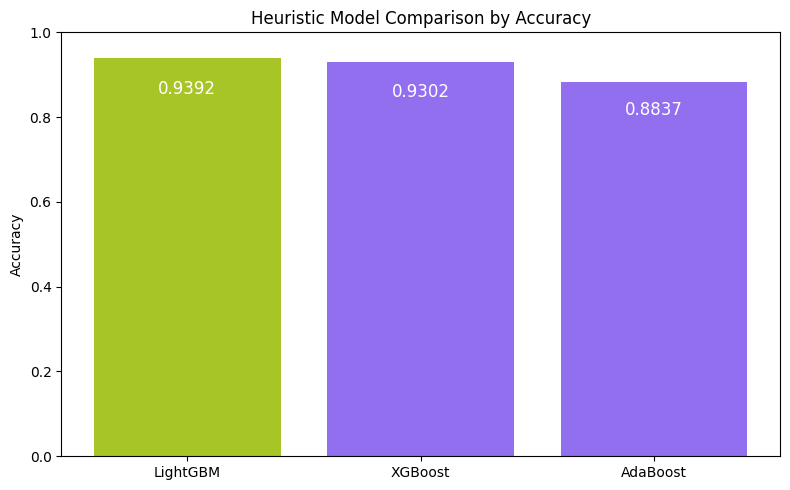

In [19]:
# Bar plot
df = pd.read_csv("../results/heuristic/heuristic_classification_performance_benchmarks.csv")

metric = "Accuracy"
best_idx = df[metric].idxmax()
colors = ["#A7C526" if i == best_idx else "#916FEE" for i in range(len(df))]

plt.figure(figsize=(8, 5))
bars = plt.bar(df["Model"], df[metric], color=colors)

for bar, val in zip(bars, df[metric]):
    plt.text(bar.get_x() + bar.get_width()/2, val * 0.90, f"{val:.4f}",
             ha='center', va='bottom', fontsize=12, color='white')

plt.title(f"Heuristic Model Comparison by {metric}")
plt.ylabel(metric)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig("../results/heuristic/heuristic_model_comparison_by_accuracy.png", dpi=300)
plt.show()

**ROC CURVE AND AUC SCORE**

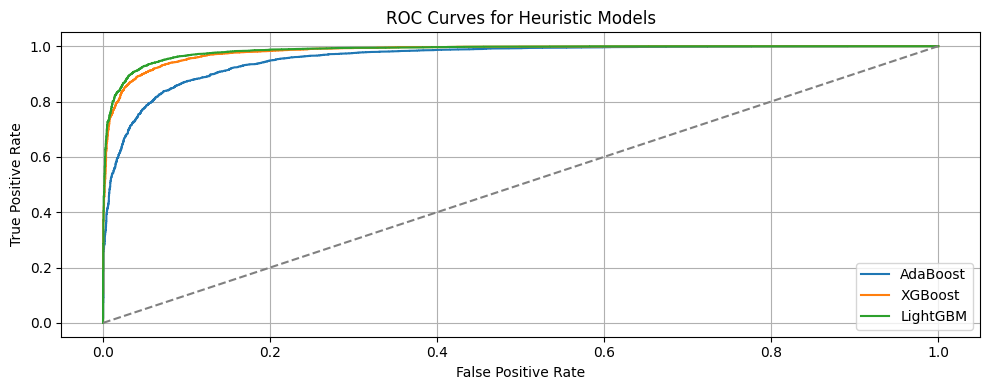


Heuristic ROC-AUC Scores:


,Model,ROC-AUC
0,LightGBM,0.9852
1,XGBoost,0.9819
2,AdaBoost,0.9564


In [ ]:
# Unified function to plot all ROC curves and display AUC scores
def plot_heuristic_roc_curves(results, y_true):
    """
    Plots ROC curves for heuristic models and displays a table of ROC-AUC scores.

    Parameters:
        results (dict): {model_name: predicted_probabilities_for_class_1}
        y_true (list/array): Ground truth labels.
    """
    plt.figure(figsize=(10, 4))
    auc_table = []

    for model_name, probs in results.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        auc_score = roc_auc_score(y_true, probs)
        plt.plot(fpr, tpr, label=f"{model_name}")
        auc_table.append({"Model": model_name, "ROC-AUC": round(auc_score, 4)})

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curves for Heuristic Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.tight_layout()
    os.makedirs("../results/heuristic", exist_ok=True)
    plt.savefig("../results/heuristic/heuristic_models_roc_curves.png", dpi=300)
    plt.show()

    # Save and display results
    df_auc = pd.DataFrame(auc_table).sort_values("ROC-AUC", ascending=False).reset_index(drop=True)
    df_auc.to_csv("../results/heuristic/heuristic_roc_auc_scores.csv", index=False)

    print("\nHeuristic ROC-AUC Scores:")
    display(df_auc)

# Create dict of model names
heuristic_probs_results = {
    "AdaBoost": adaboost_probs,
    "XGBoost": xgboost_probs,
    "LightGBM": lightgbm_probs
}

# Ground truth
y_true = y_test

# Plot and save
plot_heuristic_roc_curves(heuristic_probs_results, y_true)

**CONFUSION MATRIX AND STATISTICS**

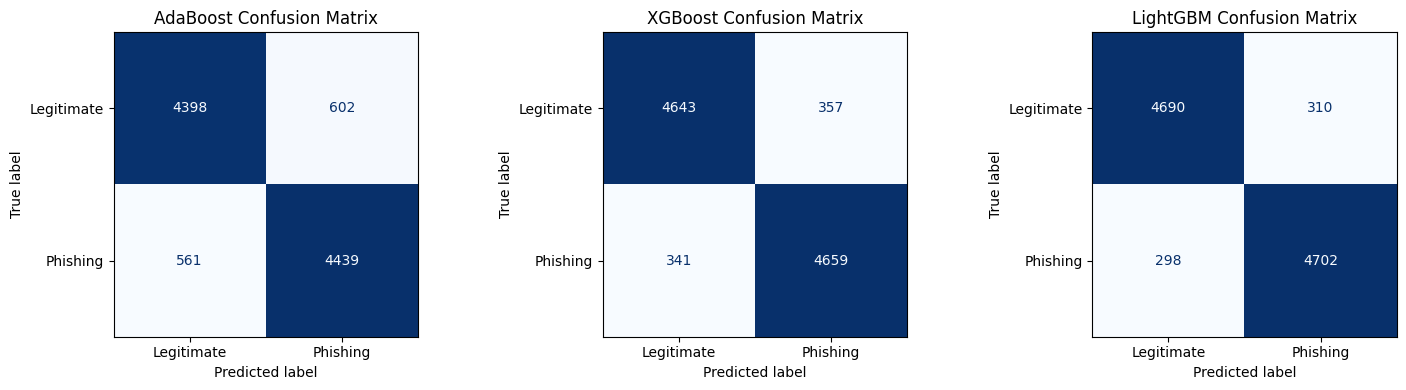


Heuristic Confusion Matrix Breakdown (%):


,True Positive (%),True Negative (%),False Positive (%),False Negative (%),Model
0,47.02,46.90,3.10,2.98,LightGBM
1,46.59,46.43,3.57,3.41,XGBoost
2,44.39,43.98,6.02,5.61,AdaBoost


In [ ]:
# Utility function to compute confusion matrix stats
def get_confusion_stats(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    return {
        "True Positive (%)": round(tp / total * 100, 2),
        "True Negative (%)": round(tn / total * 100, 2),
        "False Positive (%)": round(fp / total * 100, 2),
        "False Negative (%)": round(fn / total * 100, 2),
    }

# Unified function to plot all confusion matrices and display stats
def plot_heuristic_confusion_matrices(results, y_true):
    """
    Plots heuristic confusion matrices side by side and displays a table of TP/TN/FP/FN percentages.

    Parameters:
        results (dict): {model_name: predicted_labels}
        y_true (list/array): Ground truth labels.
    """

    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

    # If only one model, axes might not be iterable
    if n_models == 1:
        axes = [axes]

    stats_table = []

    for ax, (model_name, y_pred) in zip(axes, results.items()):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
        disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)
        ax.set_title(f"{model_name} Confusion Matrix")

        stats = get_confusion_stats(y_true, y_pred)
        stats["Model"] = model_name
        stats_table.append(stats)

    plt.tight_layout()
    os.makedirs("../results/heuristic/", exist_ok=True)
    plt.savefig("../results/heuristic/heuristic_confusion_matrices.png", bbox_inches="tight")
    plt.show()

    # Save and display results
    df_stats = pd.DataFrame(stats_table).sort_values("False Negative (%)").reset_index(drop=True)
    df_stats.to_csv("../results/heuristic/heuristic_confusion_matrix_breakdown.csv", index=False)

    print("\nHeuristic Confusion Matrix Breakdown (%):")
    display(df_stats)

# Get predictions and store in a dict
heuristic_results = {}

# AdaBoost
adaboost_preds = adaboost_model.predict(X_test_np)
heuristic_results["AdaBoost"] = adaboost_preds

# XGBoost
xgboost_preds = xgboost_model.predict(X_test_np)
heuristic_results["XGBoost"] = xgboost_preds

# LightGBM
lightgbm_preds = lightgbm_model.predict(X_test_np)
if isinstance(lightgbm_preds[0], float):
    lightgbm_preds = (lightgbm_preds >= 0.5).astype(int)
heuristic_results["LightGBM"] = lightgbm_preds

# Ground truth
y_true = y_test

# Plot and save
plot_heuristic_confusion_matrices(heuristic_results, y_true)

**INFERENCE SPEED AND MODEL SIZE**

In [ ]:
# Configurations
MODEL_DIR = "../models"

# Prepare the test set
sample_indices = df_test.index
X_speed_test_np = X_test_np[sample_indices]
y_speed_test_np = y_test.loc[sample_indices].values

# Load trained heuristic models
adaboost_model = joblib.load(f"{MODEL_DIR}/heuristic/adaboost/model.pkl")
xgboost_model = joblib.load(f"{MODEL_DIR}/heuristic/xgboost/model.pkl")
lightgbm_model = joblib.load(f"{MODEL_DIR}/heuristic/lightgbm/model.pkl")

# Function to calculate inference speed
def get_inference_speed(name, model, X, warmup=5):
    for _ in range(warmup): # Warm-up
        model.predict(X[[0]])

    start_time = time.time()
    for i in range(len(X)):
        model.predict(X[[i]])
    end_time = time.time()

    total_time = end_time - start_time
    avg_time = total_time / len(X)
    throughput = len(X) / total_time

    return {
        "Model": name,
        "Average Time per Sample (sec)": round(avg_time, 6),
        "Throughput (samples/sec)": round(throughput, 2)
    }

# Get inference speeds
inference_speed_results = []
inference_speed_results.append(get_inference_speed("AdaBoost", adaboost_model, X_speed_test_np))
inference_speed_results.append(get_inference_speed("XGBoost", xgboost_model, X_speed_test_np))
inference_speed_results.append(get_inference_speed("LightGBM", lightgbm_model, X_speed_test_np))

# Function to get model size in MB
def get_model_size(path):
    total_size = 0
    if os.path.isfile(path):
        total_size = os.path.getsize(path)
    else:
        for dirpath, _, filenames in os.walk(path):
            for f in filenames:
                total_size += os.path.getsize(os.path.join(dirpath, f))
    return round(total_size / (1024 * 1024), 2)

# Get model sizes
adaboost_size = get_model_size(f"{MODEL_DIR}/heuristic/adaboost/model.pkl")
xgboost_size = get_model_size(f"{MODEL_DIR}/heuristic/xgboost/model.pkl")
lightgbm_size = get_model_size(f"{MODEL_DIR}/heuristic/lightgbm/model.pkl")

# Add sizes to results
model_sizes = [adaboost_size, xgboost_size, lightgbm_size]
for result, size in zip(inference_speed_results, model_sizes):
    result["Model Size (MB)"] = size

# Save and display results
results_df = pd.DataFrame(inference_speed_results)
results_df = results_df.sort_values("Average Time per Sample (sec)").reset_index(drop=True)

os.makedirs("../results/heuristic", exist_ok=True)
results_df.to_csv("../results/heuristic/heuristic_speed_and_size_benchmarks.csv", index=False)

print("Heuristic Inference Speed and Model Size Benchmark Results:")
display(results_df)

Heuristic Inference Speed and Model Size Benchmark Results:


,Model,Average Time per Sample (sec),Throughput (samples/sec),Model Size (MB)
0,XGBoost,0.000272,3678.05,0.67
1,LightGBM,0.000627,1595.88,1.32
2,AdaBoost,0.026875,37.21,0.18


**FINAL HEURISTIC MODEL**

XGBoost will be used as the heuristic backbone of PhiLNet because it strikes the best balance between accuracy and speed among tree-based learners. Although LightGBM achieved slightly higher Accuracy (0.9392) and ROC-AUC (0.9852), XGBoost processes individual samples more than twice as fast (throughput = 3,678 samples/sec vs. 1,596 for LightGBM) while retaining a compact model size of 0.67 MB. This high-speed performance is crucial for real-time deployment while still maintaining strong predictive power (Accuracy = 0.9302, ROC-AUC = 0.9819) in detecting phishing signals from URLs, HTML structures, and metadata. Combined with the textual module via a meta-classifier, XGBoost reinforces PhiLNet’s robustness, ensuring fast and reliable phishing detection.

**SHAP ANALYSIS**

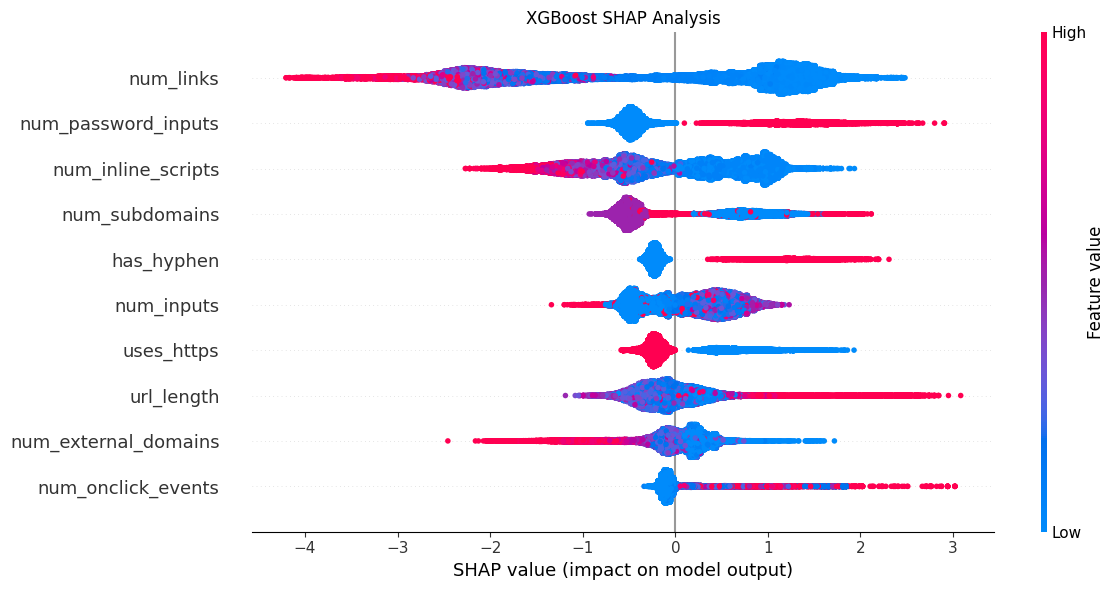

In [6]:
def plot_shap_summary(model_path, X, vectorizer, top_n):
    """
    Generate a SHAP summary plot showing top contributing features.
    """
    # Load model
    model = joblib.load(model_path)

    # Convert array to DataFrame with feature names from DictVectorizer
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

    # SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    # For binary classification → select positive class
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    # Beeswarm summary plot
    shap.summary_plot(shap_values, X, max_display=top_n, show=False)
    plt.gcf().set_size_inches(12, 6)
    plt.title("XGBoost SHAP Analysis")
    plt.tight_layout()

    os.makedirs("../results/heuristic", exist_ok=True)
    plt.savefig("../results/heuristic/heuristic_shap_analysis.png", bbox_inches="tight", dpi=300)
    plt.show()

# Get SHAP summary
plot_shap_summary(model_path="../models/heuristic/xgboost/model.pkl", X=X_train_np, vectorizer=vectorizer, top_n=10)

### **TRAIN THE FUSION MODELS**

In [3]:
logging.set_verbosity_error()

# Select textual and heuristic model
final_textual_model = "fasttext"
final_heuristic_model = "xgboost"

# Helper function for textual retraining and predictions
def train_and_get_textual_probs(train_texts, train_labels, val_texts):

    def save_fasttext_format(texts, labels, filename, max_tokens=512):
        with open(filename, "w", encoding="utf-8") as f:
            for text, label in zip(texts, labels):
                label_str = "__label__1" if label == 1 else "__label__0"
                text_clean = str(text).replace("\n", " ")
                tokens = text_clean.split()
                trimmed_text = " ".join(tokens[:max_tokens])
                f.write(f"{label_str} {trimmed_text}\n")

    with tempfile.NamedTemporaryFile(mode="w", suffix=".txt", encoding="utf-8", delete=False) as f:
        train_file = f.name
        save_fasttext_format(train_texts, train_labels, train_file)

    model = fasttext.train_supervised(
        input=train_file,
        lr=1.0,
        epoch=25,
        wordNgrams=2,
        verbose=0,
        minCount=1,
        loss='softmax',
        seed=42
    )

    probs = []
    for text in val_texts:
        text_clean = str(text).replace("\n", " ")
        labels, raw_probs = model.predict(text_clean, k=2)
        label_probs = dict(zip(labels, raw_probs))
        prob_phishing = label_probs.get("__label__1", 0.0)
        probs.append(prob_phishing)

    os.remove(train_file)
    return np.array(probs)

# Helper function for textual predictions
def get_textual_probs(model_path, texts):
    model = fasttext.load_model(model_path)
    probs = []
    for text in texts:
        text_clean = str(text).replace("\n", " ")
        labels, raw_probs = model.predict(text_clean, k=2)
        label_probs = dict(zip(labels, raw_probs))
        prob_phishing = label_probs.get("__label__1", 0.0)
        probs.append(prob_phishing)
    return np.array(probs)

# Helper function for heuristic retraining and predictions
def train_and_get_heuristic_probs(train_df, val_df):
    X_train = train_df.drop(columns=["result", "url", "visible_text"]).copy()
    y_train = train_df["result"].values
    X_val = val_df.drop(columns=["result", "url", "visible_text"]).copy()

    bool_cols = X_train.select_dtypes(include=["bool"]).columns
    X_train[bool_cols] = X_train[bool_cols].astype(int)
    X_val[bool_cols] = X_val[bool_cols].astype(int)

    vectorizer = DictVectorizer(sparse=True)
    X_train_vec = vectorizer.fit_transform(X_train.to_dict(orient="records"))
    X_val_vec = vectorizer.transform(X_val.to_dict(orient="records"))

    model = XGBClassifier(
        n_estimators=200, max_depth=6,
        learning_rate=0.1, subsample=0.8,
        colsample_bytree=0.8, gamma=0.1,
        reg_alpha=0, reg_lambda=1.0,
        scale_pos_weight=1, use_label_encoder=False,
        random_state=42
    )
    model.fit(X_train_vec, y_train)

    return model.predict_proba(X_val_vec)[:, 1]

# Helper function for heuristic predictions
def get_heuristic_probs(df, vectorizer, model):
    X_heur = df.drop(columns=["result", "url", "visible_text"])
    bool_cols = X_heur.select_dtypes(include=["bool"]).columns
    X_heur[bool_cols] = X_heur[bool_cols].astype(int)
    X_heur_vec = vectorizer.transform(X_heur.to_dict(orient="records"))
    return model.predict_proba(X_heur_vec)[:, 1]

# Fusion dataset builder
def build_fusion_datasets(textual_model_name, heuristic_model_name, df_train, df_test):
    df_oof = df_train.copy()
    labels = df_oof["result"].values

    oof_textual = np.zeros(len(df_oof))
    oof_heuristic = np.zeros(len(df_oof))

    # FUSION TRAIN SET

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(skf.split(df_oof, labels)):
        fold_train = df_oof.iloc[train_idx]
        fold_val = df_oof.iloc[val_idx]

        # Textual OOF
        oof_textual[val_idx] = train_and_get_textual_probs(
            fold_train["visible_text"].astype(str).tolist(),
            fold_train["result"],
            fold_val["visible_text"].astype(str).tolist()
        )

        # Heuristic OOF
        oof_heuristic[val_idx] = train_and_get_heuristic_probs(fold_train, fold_val)

    # Assemble OOF fusion train
    df_fusion_train = df_oof.copy()
    df_fusion_train["textual_probs"] = oof_textual
    df_fusion_train["heuristic_probs"] = oof_heuristic

    df_fusion_train["prob_diff"] = np.abs(oof_textual - oof_heuristic)
    df_fusion_train["prob_ratio"] = np.clip(oof_textual / (oof_heuristic + 1e-6), 0, 10)
    df_fusion_train["prob_mult"] = oof_textual * oof_heuristic
    df_fusion_train["abs_log_ratio"] = np.abs(np.log((oof_textual + 1e-6) / (oof_heuristic + 1e-6)))
    df_fusion_train["interaction_term"] = oof_textual**2 + oof_heuristic**2

    df_fusion_train = df_fusion_train[["result", "textual_probs", "heuristic_probs", "prob_diff", "prob_ratio", "prob_mult",
                                      "abs_log_ratio", "interaction_term"]]

    # FUSION TEST SET

    # Load pre-trained textual
    textual_model_path = Path(f"../models/textual/{textual_model_name}/model.ftz")
    df_fusion_test = df_test.copy()
    df_fusion_test["textual_probs"] = get_textual_probs(
        str(textual_model_path),
        df_fusion_test["visible_text"].astype(str).tolist()
    )

    # Load pre-trained heuristic
    heuristic_model_path = Path(f"../models/heuristic/{heuristic_model_name}/model.pkl")
    vectorizer_path = Path(f"../models/heuristic/{heuristic_model_name}/vectorizer.pkl")
    heuristic_model = joblib.load(heuristic_model_path)
    vectorizer = joblib.load(vectorizer_path)
    df_fusion_test["heuristic_probs"] = get_heuristic_probs(df_fusion_test, vectorizer, heuristic_model)

    df_fusion_test["prob_diff"] = np.abs(df_fusion_test["textual_probs"] - df_fusion_test["heuristic_probs"])
    df_fusion_test["prob_ratio"] = np.clip(df_fusion_test["textual_probs"] / (df_fusion_test["heuristic_probs"] + 1e-6), 0, 10)
    df_fusion_test["prob_mult"] = df_fusion_test["textual_probs"] * df_fusion_test["heuristic_probs"]
    df_fusion_test["abs_log_ratio"] = np.abs(np.log((df_fusion_test["textual_probs"] + 1e-6) / (df_fusion_test["heuristic_probs"] + 1e-6)))
    df_fusion_test["interaction_term"] = df_fusion_test["textual_probs"]**2 + df_fusion_test["heuristic_probs"]**2

    df_fusion_test = df_fusion_test[["result", "textual_probs", "heuristic_probs", "prob_diff", "prob_ratio", "prob_mult",
                                    "abs_log_ratio", "interaction_term"]]

    # Feature scaling
    scaler = StandardScaler()
    feature_cols = ["prob_diff", "prob_ratio", "prob_mult", "abs_log_ratio", "interaction_term"]

    df_fusion_train[feature_cols] = df_fusion_train[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    df_fusion_test[feature_cols] = df_fusion_test[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

    df_fusion_train[feature_cols] = scaler.fit_transform(df_fusion_train[feature_cols])
    df_fusion_test[feature_cols] = scaler.transform(df_fusion_test[feature_cols])

    return df_fusion_train, df_fusion_test, scaler

# Run fusion dataset builder
df_fusion_train, df_fusion_test, scaler = build_fusion_datasets(
    textual_model_name=final_textual_model,
    heuristic_model_name=final_heuristic_model,
    df_train=df_train,
    df_test=df_test
)

print("Fusion Train (OOF):")
df_fusion_train.to_csv("../data/processed/fusion_train_oof.csv", index=False)
display(df_fusion_train)

print("Fusion Test (Hold-out):")
df_fusion_test.to_csv("../data/processed/fusion_test_oof.csv", index=False)
display(df_fusion_test)

Fusion Train (OOF):


,result,textual_probs,heuristic_probs,prob_diff,prob_ratio,prob_mult,abs_log_ratio,interaction_term
0,0,0.005266,0.003987,-0.585032,0.005350,-0.958984,-0.552430,-1.036308
1,1,1.000010,0.998767,-0.585225,-0.153140,1.253226,-0.686671,1.222799
2,1,0.996616,0.982800,-0.520143,-0.146780,1.210472,-0.680508,1.179352
3,1,0.883437,0.926799,-0.367217,-0.176979,0.854513,-0.664052,0.817759
4,0,0.001051,0.004816,-0.572164,-0.541815,-0.959019,0.050163,-1.036330
...,...,...,...,...,...,...,...,...
49995,0,0.000240,0.028571,-0.445022,-0.645896,-0.959015,1.626102,-1.035434
49996,1,0.999973,0.997327,-0.577960,-0.152441,1.249954,-0.685989,1.219464
49997,0,0.013666,0.022242,-0.547265,-0.345143,-0.958357,-0.451247,-1.035587
49998,0,0.001254,0.740067,3.232288,-0.649231,-0.956976,2.404440,-0.416929


Fusion Test (Hold-out):


,result,textual_probs,heuristic_probs,prob_diff,prob_ratio,prob_mult,abs_log_ratio,interaction_term
0,0,0.001623,0.018694,-0.503295,-0.606994,-0.958963,0.496881,-1.035959
1,1,0.843177,0.929841,-0.143104,-0.200015,0.777548,-0.639862,0.745529
2,0,0.001182,0.002083,-0.586989,-0.368620,-0.959025,-0.412796,-1.036351
3,0,0.004085,0.030880,-0.452973,-0.584412,-0.958751,0.292813,-1.035260
4,1,0.999972,0.992216,-0.551513,-0.149878,1.238631,-0.683500,1.207961
...,...,...,...,...,...,...,...,...
9995,1,0.986979,0.955257,-0.427465,-0.137275,1.129281,-0.671442,1.097363
9996,1,0.989882,0.996308,-0.558394,-0.156958,1.225430,-0.684137,1.194459
9997,1,0.982086,0.980186,-0.581824,-0.152795,1.173155,-0.686335,1.141033
9998,1,0.843177,0.686163,0.221017,-0.040186,0.322454,-0.587417,0.300176


In [4]:
# Get fusion features and labels
df_fusion_train = pd.read_csv("../data/processed/fusion_train_oof.csv")
X_fusion_train = df_fusion_train[['textual_probs', 'heuristic_probs', 'prob_diff', 'prob_ratio', 'prob_mult']].values
y_fusion_train = df_fusion_train['result'].values

df_fusion_test = pd.read_csv("../data/processed/fusion_test_oof.csv")
X_fusion_test = df_fusion_test[['textual_probs', 'heuristic_probs', 'prob_diff', 'prob_ratio', 'prob_mult']].values
y_fusion_test = df_fusion_test['result'].values

#### **WEIGHTED ENSEMBLE**

In [5]:
# Function to calculate and tune ensemble weights + threshold
def optimize_weights_and_threshold(textual_probs, heuristic_probs, y_true):
    def loss_fn(params):
        w_text, w_heur, t = params
        t = min(max(t, 0), 1) # Ensure threshold stays in [0,1]
        probs = w_text * textual_probs + w_heur * heuristic_probs
        preds = (probs >= t).astype(int)
        return 1 - accuracy_score(y_true, preds)  # Minimize 1 - accuracy

    # Start with equal weights and threshold 0.5
    res = minimize(loss_fn, x0=[0.5, 0.5, 0.5], bounds=[(0,1),(0,1),(0,1)])
    optimal_w_text, optimal_w_heur, optimal_threshold = res.x
    return optimal_w_text, optimal_w_heur, optimal_threshold

textual_weight, heuristic_weight, threshold = optimize_weights_and_threshold(
    df_fusion_train["textual_probs"].values,
    df_fusion_train["heuristic_probs"].values,
    df_fusion_train["result"].values
)

print("Optimal Textual Weight:", textual_weight)
print("Optimal Heuristic Weight:", heuristic_weight)
print("Optimal Threshold:", threshold)

Optimal Textual Weight: 0.5
Optimal Heuristic Weight: 0.5
Optimal Threshold: 0.5


#### **META-CLASSIFIER**

**LOGISTIC REGRESSION**

In [6]:
# Setup
model_name = "logistic_regression"
model_dir = f"../models/fusion/{model_name}"
os.makedirs(model_dir, exist_ok=True)

# Parameter grid
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "penalty": ["l2", "none"],
    "solver": ["lbfgs", "saga"],
}

# Initialize model and cross-validation
model = LogisticRegression(random_state=42, max_iter=1000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Manual grid search with tqdm
grid = ParameterGrid(param_grid)
results = []
best_score = -np.inf
best_params = None

for params in tqdm(grid, desc="Grid Search Progress"):
    model.set_params(**params)
    scores = cross_val_score(model, X_fusion_train, y_fusion_train, cv=cv, scoring="accuracy", n_jobs=-1)
    mean_score = np.mean(scores)
    results.append({**params, "accuracy": mean_score})

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

# Save results
os.makedirs("../results/fusion", exist_ok=True)
results_df = pd.DataFrame(results)
results_df.to_csv(f"../results/fusion/{model_name}_grid_search_results.csv", index=False)

# Train model on best parameters
best_model = LogisticRegression(random_state=42, max_iter=1000, **best_params)
best_model.fit(X_fusion_train, y_fusion_train)

# Save best model and scaler
joblib.dump(best_model, os.path.join(model_dir, "model.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))
print("Logistic Regression fusion model and scaler saved!")

Grid Search Progress: 100%|████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.89it/s]

Logistic Regression fusion model and scaler saved!


**RANDOM FOREST**

In [7]:
# Setup
model_name = "random_forest"
model_dir = f"../models/fusion/{model_name}"
os.makedirs(model_dir, exist_ok=True)

# Parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 25],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "criterion": ["gini", "entropy"]
}

# Initialize model and cross-validation
model = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Manual grid search with tqdm
grid = ParameterGrid(param_grid)
results = []
best_score = -np.inf
best_params = None

for params in tqdm(grid, desc="Grid Search Progress"):
    model.set_params(**params)
    scores = cross_val_score(model, X_fusion_train, y_fusion_train, cv=cv, scoring="accuracy", n_jobs=-1)
    mean_score = np.mean(scores)
    results.append({**params, "accuracy": mean_score})

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

# Save results
os.makedirs("../results/fusion", exist_ok=True)
results_df = pd.DataFrame(results)
results_df.to_csv(f"../results/fusion/{model_name}_grid_search_results.csv", index=False)

# Train model on best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_fusion_train, y_fusion_train)

# Save best model and scaler
joblib.dump(best_model, os.path.join(model_dir, "model.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))
print("Random Forest fusion model and scaler saved!")

Grid Search Progress: 100%|████████████████████████████████████████████████████████| 324/324 [1:30:03<00:00, 16.68s/it]


Random Forest fusion model and scaler saved!


**SUPPORT VECTOR**

In [8]:
# Setup
model_name = "support_vector"
model_dir = f"../models/fusion/{model_name}"
os.makedirs(model_dir, exist_ok=True)

# Parameter grid
param_grid = {
    "C": [0.01, 0.1, 1],
    "kernel": ["linear", "rbf"],
    "class_weight": [None, "balanced"]
}

# Initialize model and cross-validation
model = SVC(probability=False, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Manual grid search with tqdm
grid = ParameterGrid(param_grid)
results = []
best_score = -np.inf
best_params = None

for params in tqdm(grid, desc="Grid Search Progress"):
    model.set_params(**params)
    scores = cross_val_score(model, X_fusion_train, y_fusion_train, cv=cv, scoring="accuracy", n_jobs=-1)
    mean_score = np.mean(scores)
    results.append({**params, "accuracy": mean_score})

    if mean_score > best_score:
        best_score = mean_score
        best_params = params

# Save results
os.makedirs("../results/fusion", exist_ok=True)
results_df = pd.DataFrame(results)
results_df.to_csv(f"../results/fusion/{model_name}_grid_search_results.csv", index=False)

# Train model on best parameters
best_model = SVC(probability=True, random_state=42, **best_params)
best_model.fit(X_fusion_train, y_fusion_train)

# Save best model and scaler
joblib.dump(best_model, os.path.join(model_dir, "model.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.pkl"))
print("Support Vector fusion model and scaler saved!")

Grid Search Progress: 100%|████████████████████████████████████████████████████████████| 12/12 [01:05<00:00,  5.46s/it]


Support Vector fusion model and scaler saved!


### **EVALUATE THE FUSION MODELS**

**CLASSIFICATION PERFORMANCE**

In [9]:
classification_performance_results = []

# Evaluate the Weighted Ensemble model
weighted_ensemble_probs = (
    df_fusion_test["textual_probs"].values * textual_weight +
    df_fusion_test["heuristic_probs"].values * heuristic_weight
)
weighted_ensemble_preds = (weighted_ensemble_probs >= 0.5).astype(int)
weighted_ensemble_report = classification_report(y_fusion_test, weighted_ensemble_preds, output_dict=True)
classification_performance_results.append({
    "Model": "Weighted Ensemble",
    "Accuracy": weighted_ensemble_report["accuracy"],
    "Precision": weighted_ensemble_report["weighted avg"]["precision"],
    "Recall": weighted_ensemble_report["weighted avg"]["recall"],
    "F1-Score": weighted_ensemble_report["weighted avg"]["f1-score"]
})

# Evaluate the trained Logistic Regression model
logistic_regression_model = joblib.load("../models/fusion/logistic_regression/model.pkl")
logistic_regression_preds = logistic_regression_model.predict(X_fusion_test)
logistic_regression_probs = logistic_regression_model.predict_proba(X_fusion_test)[:, 1]

classification_performance_results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_fusion_test, logistic_regression_preds),
    "Precision": precision_score(y_fusion_test, logistic_regression_preds),
    "Recall": recall_score(y_fusion_test, logistic_regression_preds),
    "F1-Score": f1_score(y_fusion_test, logistic_regression_preds)
})

# Evaluate the trained Random Forest model
random_forest_model = joblib.load("../models/fusion/random_forest/model.pkl")
random_forest_preds = random_forest_model.predict(X_fusion_test)
random_forest_probs = random_forest_model.predict_proba(X_fusion_test)[:, 1]

classification_performance_results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_fusion_test, random_forest_preds),
    "Precision": precision_score(y_fusion_test, random_forest_preds),
    "Recall": recall_score(y_fusion_test, random_forest_preds),
    "F1-Score": f1_score(y_fusion_test, random_forest_preds)
})

# Evaluate the trained Support Vector model
support_vector_model = joblib.load("../models/fusion/support_vector/model.pkl")
support_vector_preds = support_vector_model.predict(X_fusion_test)
support_vector_probs = support_vector_model.predict_proba(X_fusion_test)[:, 1]

classification_performance_results.append({
    "Model": "Support Vector",
    "Accuracy": accuracy_score(y_fusion_test, support_vector_preds),
    "Precision": precision_score(y_fusion_test, support_vector_preds),
    "Recall": recall_score(y_fusion_test, support_vector_preds),
    "F1-Score": f1_score(y_fusion_test, support_vector_preds)
})

# Save and display results
classification_performance_results_df = pd.DataFrame(classification_performance_results)
classification_performance_results_df = classification_performance_results_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

os.makedirs("../results/fusion", exist_ok=True)
classification_performance_results_df.to_csv("../results/fusion/fusion_classification_performance_benchmarks.csv", index=False)

print("Fusion Classification Performance Benchmark Results:")
display(classification_performance_results_df)

Fusion Classification Performance Benchmark Results:


,Model,Accuracy,Precision,Recall,F1-Score
0,Weighted Ensemble,0.9661,0.966107,0.9661,0.966100
1,Random Forest,0.9657,0.964678,0.9668,0.965738
2,Logistic Regression,0.9651,0.968567,0.9614,0.964970
3,Support Vector,0.9649,0.965552,0.9642,0.964875


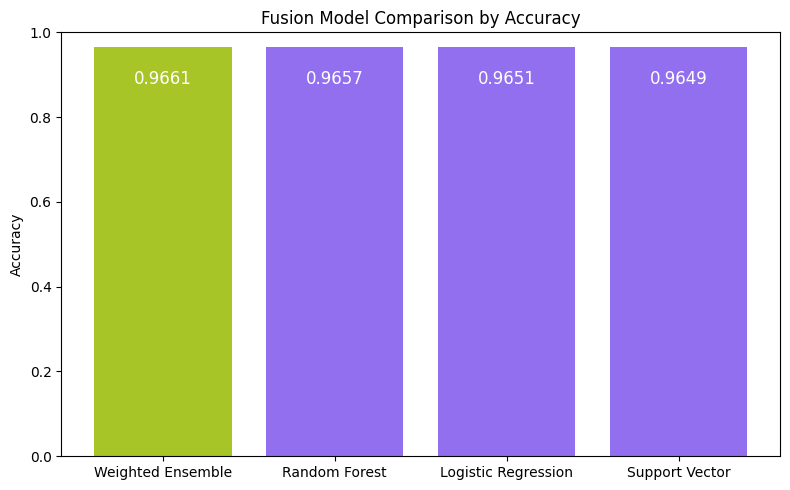

In [10]:
# Bar plot
df = pd.read_csv("../results/fusion/fusion_classification_performance_benchmarks.csv")

metric = "Accuracy"
best_idx = df[metric].idxmax()
colors = ["#A7C526" if i == best_idx else "#916FEE" for i in range(len(df))]

plt.figure(figsize=(8, 5))
bars = plt.bar(df["Model"], df[metric], color=colors)

for bar, val in zip(bars, df[metric]):
    plt.text(bar.get_x() + bar.get_width()/2, val * 0.90, f"{val:.4f}",
             ha='center', va='bottom', fontsize=12, color='white')

plt.title(f"Fusion Model Comparison by {metric}")
plt.ylabel(metric)
plt.ylim(0, 1.0)
plt.tight_layout()
plt.savefig("../results/fusion/fusion_model_comparison_by_accuracy.png", dpi=300)
plt.show()

**ROC CURVE AND AUC SCORE**

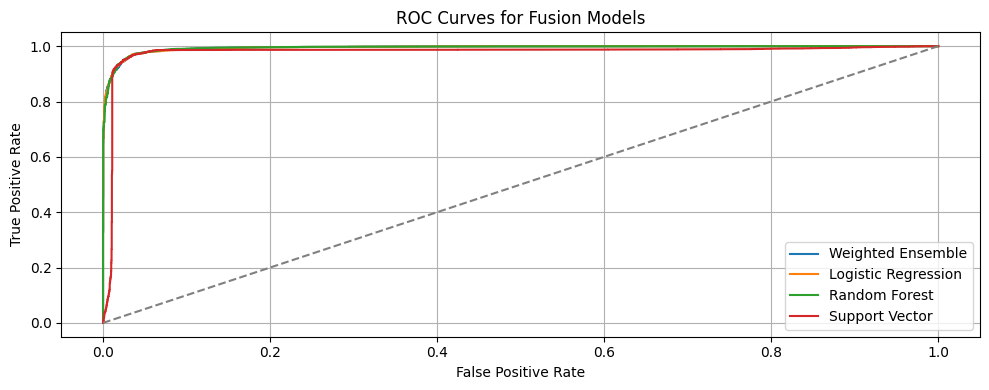


Fusion ROC-AUC Scores:


,Model,ROC-AUC
0,Weighted Ensemble,0.9943
1,Random Forest,0.9943
2,Logistic Regression,0.9941
3,Support Vector,0.9779


In [11]:
# Unified function to plot all ROC curves and display AUC scores
def plot_fusion_roc_curves(results, y_true):
    """
    Plots ROC curves for fusion models and displays a table of ROC-AUC scores.

    Parameters:
        results (dict): {model_name: predicted_probabilities_for_class_1}
        y_true (list/array): Ground truth labels.
    """
    plt.figure(figsize=(10, 4))
    auc_table = []

    for model_name, probs in results.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        auc_score = roc_auc_score(y_true, probs)
        plt.plot(fpr, tpr, label=f"{model_name}")
        auc_table.append({"Model": model_name, "ROC-AUC": round(auc_score, 4)})

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curves for Fusion Models")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.tight_layout()
    os.makedirs("../results/fusion", exist_ok=True)
    plt.savefig("../results/fusion/fusion_models_roc_curves.png", dpi=300)
    plt.show()

    # Save and display results
    df_auc = pd.DataFrame(auc_table).sort_values("ROC-AUC", ascending=False).reset_index(drop=True)
    df_auc.to_csv("../results/fusion/fusion_roc_auc_scores.csv", index=False)

    print("\nFusion ROC-AUC Scores:")
    display(df_auc)

# Create dict of model names
fusion_probs_results = {
    "Weighted Ensemble": weighted_ensemble_probs,
    "Logistic Regression": logistic_regression_probs,
    "Random Forest": random_forest_probs,
    "Support Vector": support_vector_probs
}

# Ground truth
y_true = y_fusion_test

# Plot and save
plot_fusion_roc_curves(fusion_probs_results, y_true)

**CONFUSION MATRIX AND STATISTICS**

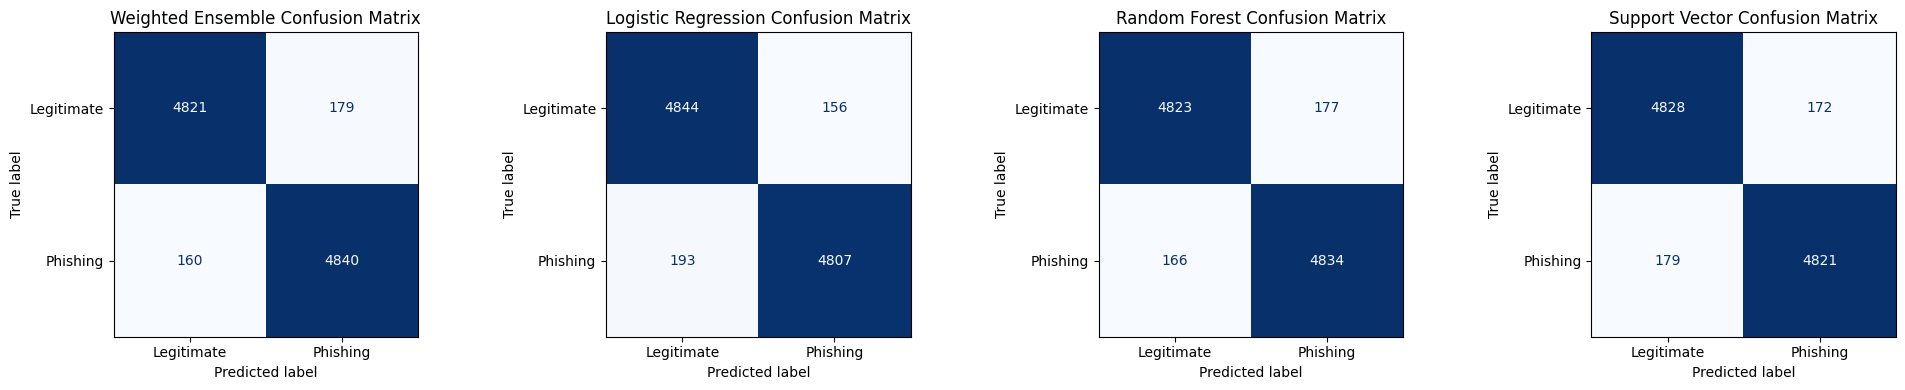


Fusion Confusion Matrix Breakdown (%):


,True Positive (%),True Negative (%),False Positive (%),False Negative (%),Model
0,48.40,48.21,1.79,1.60,Weighted Ensemble
1,48.34,48.23,1.77,1.66,Random Forest
2,48.21,48.28,1.72,1.79,Support Vector
3,48.07,48.44,1.56,1.93,Logistic Regression


In [12]:
# Utility function to compute confusion matrix stats
def get_confusion_stats(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp
    return {
        "True Positive (%)": round(tp / total * 100, 2),
        "True Negative (%)": round(tn / total * 100, 2),
        "False Positive (%)": round(fp / total * 100, 2),
        "False Negative (%)": round(fn / total * 100, 2),
    }

# Unified function to plot all confusion matrices and display stats
def plot_fusion_confusion_matrices(results, y_true):
    """
    Plots fusion confusion matrices side by side and displays a table of TP/TN/FP/FN percentages.

    Parameters:
        results (dict): {model_name: predicted_labels}
        y_true (list/array): Ground truth labels.
    """

    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

    # If only one model, axes might not be iterable
    if n_models == 1:
        axes = [axes]

    stats_table = []

    for ax, (model_name, y_pred) in zip(axes, results.items()):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
        disp.plot(cmap="Blues", values_format="d", ax=ax, colorbar=False)
        ax.set_title(f"{model_name} Confusion Matrix")

        stats = get_confusion_stats(y_true, y_pred)
        stats["Model"] = model_name
        stats_table.append(stats)

    plt.tight_layout()
    os.makedirs("../results/fusion", exist_ok=True)
    plt.savefig("../results/fusion/fusion_confusion_matrices.png", bbox_inches="tight")
    plt.show()

    # Save and display results
    df_stats = pd.DataFrame(stats_table).sort_values("False Negative (%)").reset_index(drop=True)
    df_stats.to_csv("../results/fusion/fusion_confusion_matrix_breakdown.csv", index=False)

    print("\nFusion Confusion Matrix Breakdown (%):")
    display(df_stats)

# Get predictions and store in a dict
fusion_results = {}

# Weighted Ensemble
fusion_results["Weighted Ensemble"] = weighted_ensemble_preds

# Logistic Regression
logistic_regression_preds = logistic_regression_model.predict(X_fusion_test)
fusion_results["Logistic Regression"] = logistic_regression_preds

# Random Forest
random_forest_preds = random_forest_model.predict(X_fusion_test)
fusion_results["Random Forest"] = random_forest_preds

# Support Vector
support_vector_preds = support_vector_model.predict(X_fusion_test)
fusion_results["Support Vector"] = support_vector_preds

# Ground truth
y_true = y_fusion_test

# Plot and save
plot_fusion_confusion_matrices(fusion_results, y_true)

**INFERENCE SPEED AND MODEL SIZE**

In [13]:
# Configurations
MODEL_DIR = "../models"

# Prepare the test set
X_speed_test_np = X_fusion_test
y_speed_test_np = y_fusion_test

# Load trained fusion models
logistic_model = joblib.load(f"{MODEL_DIR}/fusion/logistic_regression/model.pkl")
random_forest_model = joblib.load(f"{MODEL_DIR}/fusion/random_forest/model.pkl")
support_vector_model = joblib.load(f"{MODEL_DIR}/fusion/support_vector/model.pkl")

# Function to compute weighted ensemble manually
def get_weighted_ensemble_speed(X, textual_weight, heuristic_weight, warmup=5):
    def predict_single(sample):
        prob = sample[0] * textual_weight + sample[1] * heuristic_weight
        return int(prob >= 0.5)

    for _ in range(warmup): # Warm-up
        predict_single(X[0])

    start_time = time.time()
    for i in range(len(X)):
        predict_single(X[i])
    end_time = time.time()

    total_time = end_time - start_time
    avg_time = total_time / len(X)
    throughput = len(X) / total_time

    return {
        "Model": "Weighted Ensemble",
        "Average Time per Sample (sec)": round(avg_time, 6),
        "Throughput (samples/sec)": round(throughput, 2)
    }

# Function to calculate inference speed
def get_inference_speed(name, model, X, warmup=5):
    for _ in range(warmup): # Warm-up
        model.predict(X[[0]])

    start_time = time.time()
    for i in range(len(X)):
        model.predict(X[[i]])
    end_time = time.time()

    total_time = end_time - start_time
    avg_time = total_time / len(X)
    throughput = len(X) / total_time

    return {
        "Model": name,
        "Average Time per Sample (sec)": round(avg_time, 6),
        "Throughput (samples/sec)": round(throughput, 2)
    }

# Get inference speeds
inference_speed_results = []
inference_speed_results.append(get_weighted_ensemble_speed(X_speed_test_np, textual_weight, heuristic_weight))
inference_speed_results.append(get_inference_speed("Logistic Regression", logistic_model, X_speed_test_np))
inference_speed_results.append(get_inference_speed("Random Forest", random_forest_model, X_speed_test_np))
inference_speed_results.append(get_inference_speed("Support Vector", support_vector_model, X_speed_test_np))

# Function to get model size in MB
def get_model_size(path):
    total_size = 0
    if os.path.isfile(path):
        total_size = os.path.getsize(path)
    else:
        for dirpath, _, filenames in os.walk(path):
            for f in filenames:
                total_size += os.path.getsize(os.path.join(dirpath, f))
    return round(total_size / (1024 * 1024), 2)

# Get model sizes
weighted_ensemble_size = 0.0 # Weighted Ensemble is just a formula
logistic_regression_size = get_model_size(f"{MODEL_DIR}/fusion/logistic_regression/model.pkl")
random_forest_size = get_model_size(f"{MODEL_DIR}/fusion/random_forest/model.pkl")
support_vector_size = get_model_size(f"{MODEL_DIR}/fusion/support_vector/model.pkl")

# Add sizes to results
model_sizes = [weighted_ensemble_size, logistic_regression_size, random_forest_size, support_vector_size]
for result, size in zip(inference_speed_results, model_sizes):
    result["Model Size (MB)"] = size

# Save and display results
results_df = pd.DataFrame(inference_speed_results)
results_df = results_df.sort_values("Average Time per Sample (sec)").reset_index(drop=True)

os.makedirs("../results/fusion", exist_ok=True)
results_df.to_csv("../results/fusion/fusion_speed_and_size_benchmarks.csv", index=False)

print("Fusion Inference Speed and Model Size Benchmark Results:")
display(results_df)

Fusion Inference Speed and Model Size Benchmark Results:


,Model,Average Time per Sample (sec),Throughput (samples/sec),Model Size (MB)
0,Weighted Ensemble,0.000001,1536600.23,0.00
1,Logistic Regression,0.000063,15826.36,0.00
2,Support Vector,0.000292,3421.65,0.22
3,Random Forest,0.003794,263.59,4.86


**FINAL FUSION MODEL**

The Weighted Ensemble is selected as the final fusion model because it provides the best balance between simplicity, interpretability, and predictive performance. By combining the textual model (FastText) and the heuristic model (XGBoost) with optimized weights, the ensemble achieves high accuracy (0.9661) while maintaining a low false negative rate, which is crucial for minimizing missed phishing detections. Unlike more complex meta-classifiers, the weighted ensemble directly leverages the strengths of both modalities—textual probabilities and heuristic signals—without introducing additional model complexity or potential overfitting. Its inference is extremely fast (≈0.000001 sec per sample) and lightweight (minimal memory footprint), making it ideal for practical deployment. The performance demonstrates that a carefully weighted combination of textual and heuristic modules can match or exceed the effectiveness of more complex fusion approaches while remaining simple and robust.

The final PhiLNet architecture prioritizes both lightweight speed and robust multi-modality. By integrating FastText for deep textual analysis, XGBoost for structured heuristic evaluation, and a Weighted Ensemble for fusion, the framework leverages complementary strengths across different modalities. This design ensures that PhiLNet maintains real-time performance suitable for deployment while remaining resilient against adversarial tactics that may target only one feature type. The result is a phishing detection system that is extremely efficient for practical use while robust enough to maintain high reliability over time.

### **FUSION ERROR ANALYSIS**

In [14]:
# Prepare fusion-level features for error analysis
df_fusion_test_clean = df_fusion_test.drop(columns=["result"])

# Combine original test set and fusion-level features
df_error_analysis = pd.concat([
    df_test.reset_index(drop=True), 
    df_fusion_test_clean.reset_index(drop=True)
], axis=1)

# Attach weighted ensemble probabilities
df_error_analysis["fusion_probs"] = weighted_ensemble_probs

# Attach weighted ensemble predictions
df_error_analysis["fusion_pred"] = weighted_ensemble_preds

# Mark whether each prediction was correct
df_error_analysis["correct"] = df_error_analysis["result"] == df_error_analysis["fusion_pred"]

# Split into misses and correct predictions
df_misses = df_error_analysis[df_error_analysis["correct"] == False]
df_correct = df_error_analysis[df_error_analysis["correct"] == True]
df_misses.to_csv("../results/fusion/error_list.csv", index=False)

# Print summary statistics
print("Total incorrect predictions:", len(df_misses))
print("Total correct predictions:", len(df_correct))
print("Error rate:", len(df_misses) / len(df_error_analysis))

# 1. Misses by true label
print("\nMisses by true label:")
print(df_misses["result"].value_counts())

# 2. False positives and false negatives
false_positives = df_misses[(df_misses["fusion_pred"] == 1) & (df_misses["result"] == 0)]
false_negatives = df_misses[(df_misses["fusion_pred"] == 0) & (df_misses["result"] == 1)]
print("\nFalse Positives:", len(false_positives))
print("False Negatives:", len(false_negatives))

# 3. Which model was closer for each miss
df_misses["textual_closer"] = (
    np.abs(df_misses["textual_probs"] - df_misses["result"]) <
    np.abs(df_misses["heuristic_probs"] - df_misses["result"])
)
print("\nMisses where textual model was closer:", df_misses["textual_closer"].sum())
print("Misses where heuristic model was closer:", (~df_misses["textual_closer"]).sum())

# 4. Probability statistics for misses
print("\nAverage probabilities in misses:")
print(df_misses[["textual_probs", "heuristic_probs", "fusion_probs"]].mean())

# 5. Top disagreements (highest textual vs heuristic disagreement)
top_conflicts = df_misses.sort_values("abs_log_ratio", ascending=False).head(10).reset_index(drop=True)
top_conflicts.to_csv("../results/fusion/top_disagreements.csv", index=False)
print("\nTop 10 disagreements:")
display(top_conflicts)

# 6. Correlation of numeric features with correctness
numeric_features = df_error_analysis.select_dtypes(include=np.number).columns.tolist()
numeric_features = [f for f in numeric_features if f not in ["result", "fusion_pred", "correct"]]

corr_with_error = df_error_analysis[numeric_features + ["correct"]].corr()["correct"].sort_values()
print("\nCorrelation of numeric features with correctness:")
print(corr_with_error)

Total incorrect predictions: 339
Total correct predictions: 9661
Error rate: 0.0339

Misses by true label:
result
0    179
1    160
Name: count, dtype: int64

False Positives: 179
False Negatives: 160

Misses where textual model was closer: 112
Misses where heuristic model was closer: 227

Average probabilities in misses:
textual_probs      0.541798
heuristic_probs    0.484298
fusion_probs       0.513048
dtype: float64

Top 10 disagreements:


,url,result,visible_text,url_length,num_dots,has_at_symbol,uses_https,suspicious_words,has_ip_address,num_subdomains,is_suspicious_tld,has_hyphen,url_has_encoding,url_has_long_query,url_ends_with_exe,num_forms,num_inputs,num_links,num_password_inputs,num_hidden_inputs,num_onclick_events,num_hidden_elements,has_iframe,has_zero_sized_iframe,suspicious_form_action,has_script_eval,has_base64_in_js,num_inline_scripts,has_network_js,external_js_count,external_iframe_count,num_external_domains,textual_probs,heuristic_probs,prob_diff,prob_ratio,prob_mult,abs_log_ratio,interaction_term,fusion_probs,fusion_pred,correct,textual_closer
0,http://whitesourceentertainment.com/rwwt/348ie...,1,403 - forbidden 403 forbidden,280,3,True,False,1,False,0,False,False,False,True,False,0,0,0,0,0,0,0,False,False,False,False,False,0,False,0,0,0,0.000010,0.999891,4.583515,-0.650067,-0.959008,4.839099,0.094356,0.499950,0,False,False
1,http://lavitaworld.com/system/zcvb/Docuii/home/,1,google docs,47,1,False,False,0,False,0,False,False,False,False,False,1,3,0,1,0,0,0,False,False,False,False,False,1,False,0,0,0,0.000015,0.997475,4.570985,-0.650064,-0.958998,4.667210,0.088898,0.498745,0,False,False
2,https://chocolatelinesq13.live/,1,under construction,31,1,False,True,0,False,0,False,False,False,False,False,1,2,0,0,2,0,0,False,False,False,False,False,0,False,0,0,0,0.000092,0.876403,3.943943,-0.650019,-0.958852,3.746329,-0.167687,0.438247,0,False,False
3,https://netregistry.com.au.login.netregistrypr...,1,log into the console netregistry,710,5,False,True,1,False,4,False,False,False,True,False,0,0,0,0,0,0,0,False,False,False,True,False,2,False,1,0,1,0.000261,0.990666,4.534476,-0.649941,-0.958459,3.305511,0.073590,0.495464,0,False,False
4,https://monteage.in/covid19/assets/jse/id/8595d/,1,404 - file or directory not found. server erro...,48,1,False,True,0,False,0,False,False,False,False,False,0,0,0,0,0,0,0,False,False,False,False,False,0,False,0,0,0,0.000200,0.512003,2.057332,-0.649878,-0.958804,3.113860,-0.739879,0.256102,0,False,False
5,https://observatoriodeourofino.com.br/2019/06/...,1,sicoob credivass promove o dia de cooperar em ...,105,2,False,True,0,False,1,False,False,False,False,False,2,3,111,0,0,0,1,True,True,False,False,True,21,False,10,2,9,0.856235,0.000603,3.836915,4.313078,-0.957887,2.829338,-0.207207,0.428419,0,False,True
6,http://superlite.com.vn/wp-includes/js/dist/ve...,1,payment username password login,68,2,False,False,0,False,1,False,False,False,False,False,1,2,0,1,0,0,0,False,False,False,False,False,0,False,0,0,1,0.000842,0.990043,4.528239,-0.649649,-0.957183,2.737852,0.072195,0.495443,0,False,False
7,https://steampowered.codes,1,welcome to steam login store featured explore ...,26,1,False,True,0,False,0,False,False,False,False,False,2,20,279,0,3,34,0,False,False,False,False,False,12,False,8,0,0,0.001214,0.819255,3.642352,-0.649336,-0.956827,2.469088,-0.277279,0.410235,0,False,False
8,http://ministeriodesalud.chubut.gov.ar/wp-cont...,1,60h64 with raisins oatmeal banana muffins amon...,117,4,False,False,0,False,2,False,False,False,False,False,0,0,0,0,0,0,0,False,False,False,False,False,1,False,0,0,0,0.002789,0.902837,4.066800,-0.648538,-0.953452,2.113368,-0.114487,0.452813,0,False,False
9,http://forestinhouse.com/wp-includes/Text/priv...,1,4v459fm how banana - yogurt them without make ...,96,2,False,False,0,False,0,False,False,False,False,False,0,0,0,0,0,0,0,False,False,False,False,False,2,False,1,0,1,0.004285,0.893111,4.008722,-0.647691,-0.950555,1.900198,-0.134229,0.448698,0,False,False



Correlation of numeric features with correctness:
prob_diff               -0.307741
prob_ratio              -0.059444
abs_log_ratio           -0.022427
textual_probs           -0.017441
fusion_probs            -0.006046
num_onclick_events       0.005926
heuristic_probs          0.006628
num_hidden_elements      0.010622
num_hidden_inputs        0.011400
external_js_count        0.011563
num_subdomains           0.011924
num_dots                 0.016847
suspicious_words         0.023179
num_inputs               0.023827
url_length               0.031700
interaction_term         0.034633
num_password_inputs      0.038501
external_iframe_count    0.039656
num_external_domains     0.043134
num_forms                0.044400
num_inline_scripts       0.045434
num_links                0.051138
prob_mult                0.077338
correct                  1.000000
Name: correct, dtype: float64


### **ABLATION STUDIES**

**Text-Only vs. Heuristic-Only vs. Fusion**

In [3]:
# Import and split dataset
dataset_extra = pd.read_parquet("../data/processed/dataset_extra_feature.parquet")
legit_df = dataset_extra[dataset_extra["result"] == 0].sample(200, random_state=42)
phish_df = dataset_extra[dataset_extra["result"] == 1]

# Synthesize phishing instances
n_phish_needed = 200
n_phish_original = len(phish_df)
n_variants = max(1, n_phish_needed // n_phish_original)

synthetic_phish = synthesize_dataset(
    phish_df,
    label_col="result",
    target_label=1,
    synthesize_legit=False,
    n_variants=n_variants,
    seed=42,
    keep_original_legit=False,
)

if len(synthetic_phish) > 200:
    synthetic_phish = synthetic_phish.sample(200, random_state=42)

# Combine with legitimate rows for evaluation
eval_df = pd.concat([legit_df, synthetic_phish], ignore_index=True).sample(frac=1, random_state=42)

# Run the benchmark
results = run_ablation_benchmark(
    eval_df,
    label_col="result",
    n_variants=1,
    synth_seed=42,
    textual_model_path="../models/textual/fasttext/model.ftz",
    vectorizer_path="../models/heuristic/xgboost/vectorizer.pkl",
    heuristic_model_path="../models/heuristic/xgboost/model.pkl",
    save_csv="../results/ablation_results.csv",
    sample_limit=None
)
display(results)

[INFO] Synthesizing dataset (target_label=1)... synthesize_legit=False, keep_original_legit=True
[INFO] Sampled rows: 400 | Synthesized rows: 400


[INFO] Evaluating on original data...
[INFO] Evaluating on synthesized (obfuscated) data...
[INFO] Saved metrics to ../results/ablation_results.csv


,auc,accuracy,precision,recall,f1,fpr,fnr,specificity,mcc,pr_auc,n_samples,dataset
method,,,,,,,,,,,,
textual,0.965400,0.9325,0.952880,0.910,0.930946,0.045,0.090,0.955,0.865877,0.962295,400,original
heuristic,0.984950,0.9350,0.943878,0.925,0.934343,0.055,0.075,0.945,0.870174,0.985468,400,original
fusion,0.992850,0.9475,0.963731,0.930,0.946565,0.035,0.070,0.965,0.895549,0.993504,400,original
textual,0.942225,0.8825,0.947368,0.810,0.873315,0.045,0.190,0.955,0.773171,0.938676,400,synthesized
heuristic,0.989150,0.9375,0.944162,0.930,0.937028,0.055,0.070,0.945,0.875098,0.989107,400,synthesized
fusion,0.991950,0.9300,0.962366,0.895,0.927461,0.035,0.105,0.965,0.862115,0.991895,400,synthesized


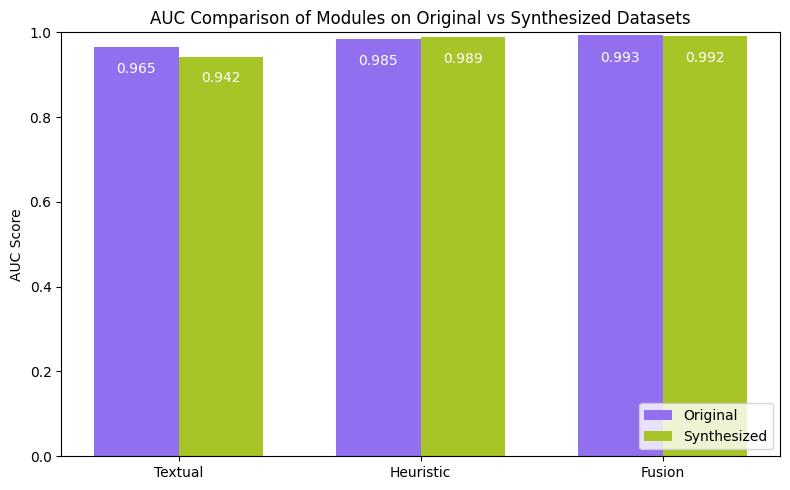

In [4]:
# Bar plot
plt.figure(figsize=(8, 5))
bar_width = 0.35

methods = results.index.unique()
x = range(len(methods))

original_scores = results[results["dataset"] == "original"]["auc"].values
synthesized_scores = results[results["dataset"] == "synthesized"]["auc"].values

palette = {"Original": "#916FEE", "Synthesized": "#A7C526"}

bars1 = plt.bar([i - bar_width/2 for i in x], original_scores, width=bar_width, label="Original", color=palette["Original"])
bars2 = plt.bar([i + bar_width/2 for i in x], synthesized_scores, width=bar_width, label="Synthesized", color=palette["Synthesized"])

# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2, height * 0.93, 
        f"{height:.3f}", ha="center", va="bottom", fontsize=10, color='white'
    )

plt.xticks(x, [m.title() for m in methods])
plt.ylabel("AUC Score")
plt.title("AUC Comparison of Modules on Original vs Synthesized Datasets")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("../results/auc_comparison_of_models_ablation.png", dpi=300)
plt.show()

Based on the ablation study results with both original and synthetic phishing datasets, several key insights emerge. The textual-only model demonstrates high precision but is highly sensitive to obfuscation: its false negative rate nearly doubles under synthetic phishing, and MCC and PR-AUC decline, indicating a substantial drop in reliability. The heuristic-only model, by contrast, remains robust against adversarial modifications, with stable or slightly improved FNR, MCC, and PR-AUC, showing that feature-based signals like URL characteristics, scripts, and forms provide strong, attack-resilient cues. The fusion model, combining textual and heuristic predictions, maintains high overall performance, balancing precision and recall while mitigating textual vulnerabilities, though it still experiences a moderate increase in FNR due to textual degradation. Across all models, false positive rates remain low and stable, preserving usability by minimizing incorrect blocking of legitimate sites. These results highlight that textual models alone are fragile under red-teaming attacks, heuristic features are essential for robustness, and fusion approaches offer the most practical balance for real-world phishing detection systems.